In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoProcessor
import numpy as np
from PIL import Image
import lens

torch.set_grad_enabled(False)

# Загрузка модели и процессора
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16
).to(mps_device)

/Users/hq-t77vj4f4r7/Documents/PersonalProjects/tlab_llm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


In [3]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What does the man hold?"}
        ]
    },
    {"role": "assistant", "content": [{"type" : "text", "text": "He is holding a "}]}
]

#image = np.random.rand(3,512,512)
image = Image.open('data/bashkir.jpg')
#inputs = processor(text=["'<|image_pad|>'На картинке изображен "], images=[image], padding=True, return_tensors="pt")
#processor.decode(inputs["input_ids"][0])
prompt = processor.apply_chat_template(messages, continue_final_message=True, add_generation_prompt=False)
inputs = processor(text=prompt, images=[image], return_tensors="pt").to(mps_device)

In [4]:
model

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [5]:
logit_lens = lens.LogitLens(model.model.layers, model.lm_head, tokenizer=processor.tokenizer, processor=processor)
logit_lens.register()

vision_lens = lens.LogitLens(model.visual.blocks, model.visual.merger, tokenizer=processor.tokenizer, processor=processor)
vision_lens.register()

projector_lens = lens.LogitLens(model.visual.merger, model.lm_head, tokenizer=processor.tokenizer, processor=processor)
projector_lens.register()

#vision_embedding_lens = lens.LogitLens(model.model.vision_model.embeddings.patch_embedding, model.lm_head, tokenizer=processor.tokenizer, processor=processor)
#vision_embedding_lens.register()

In [6]:
import torch.nn.functional as F

_ = model(**inputs)

In [7]:
logit_lens.visualize_text_predictions(norm=model.model.norm, top_k=5)

RuntimeError: MPS backend out of memory (MPS allocated: 17.79 GB, other allocations: 92.83 MB, max allowed: 18.13 GB). Tried to allocate 408.03 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

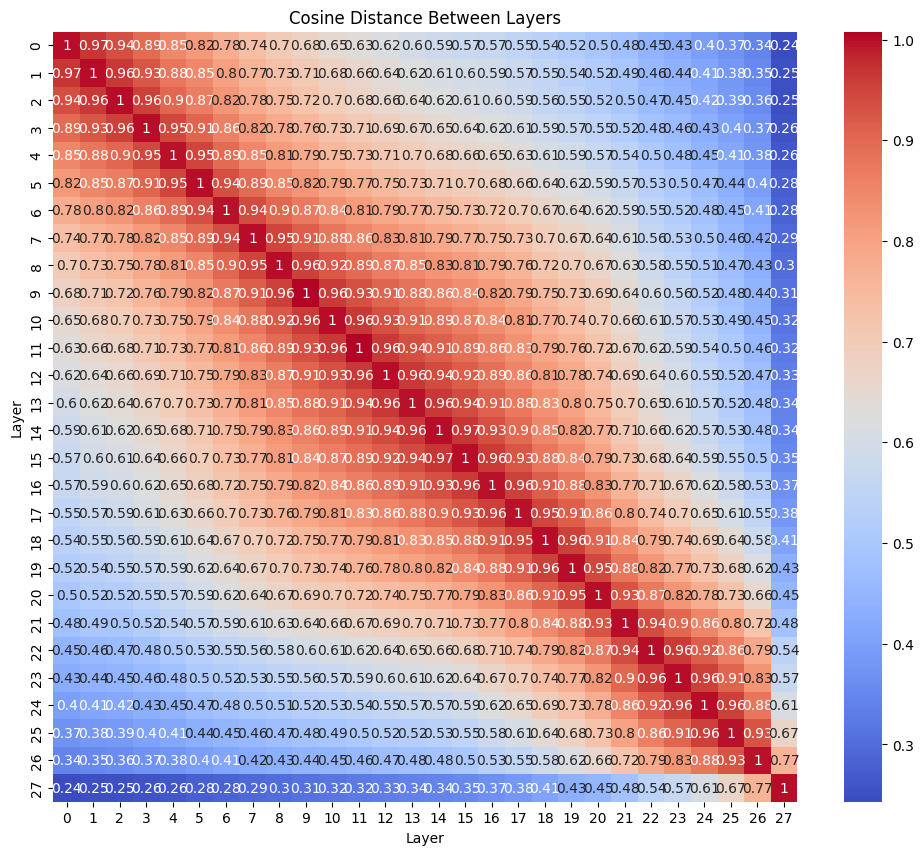

In [8]:
logit_lens.cosine_distance_heatmap(norm = model.model.norm)

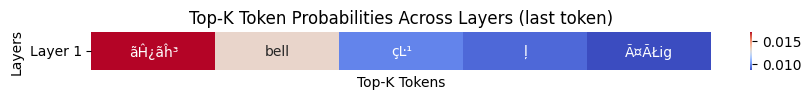

[['ãĤ¿ãĥ³' 'bell' 'çĿ¹' 'ļ' 'Ã¤ÃŁig']]


In [ ]:
projector_lens.visualize_text_predictions(norm=model.model.norm, top_k=5)

In [10]:
vision_lens.activations[0].shape

torch.Size([1280])

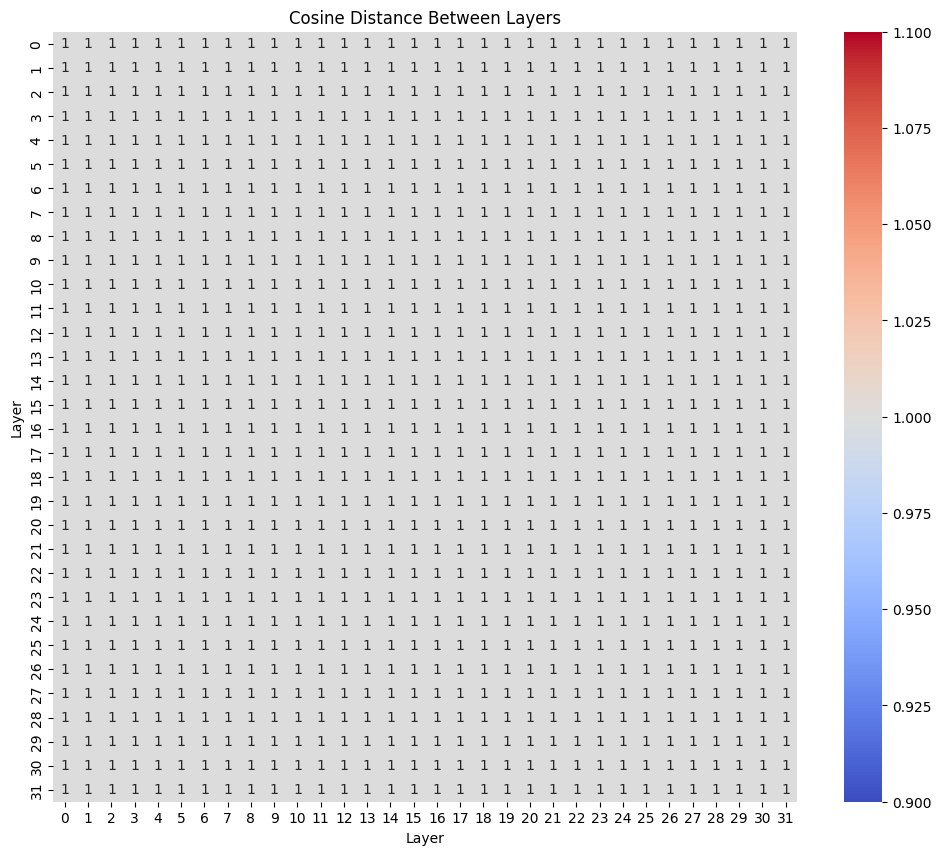

In [11]:
vision_lens.cosine_distance_heatmap(norm = lambda x: x)

In [12]:
pixel_mask = (inputs['input_ids'] == processor.tokenizer.encode(processor.image_token)[0])[0]

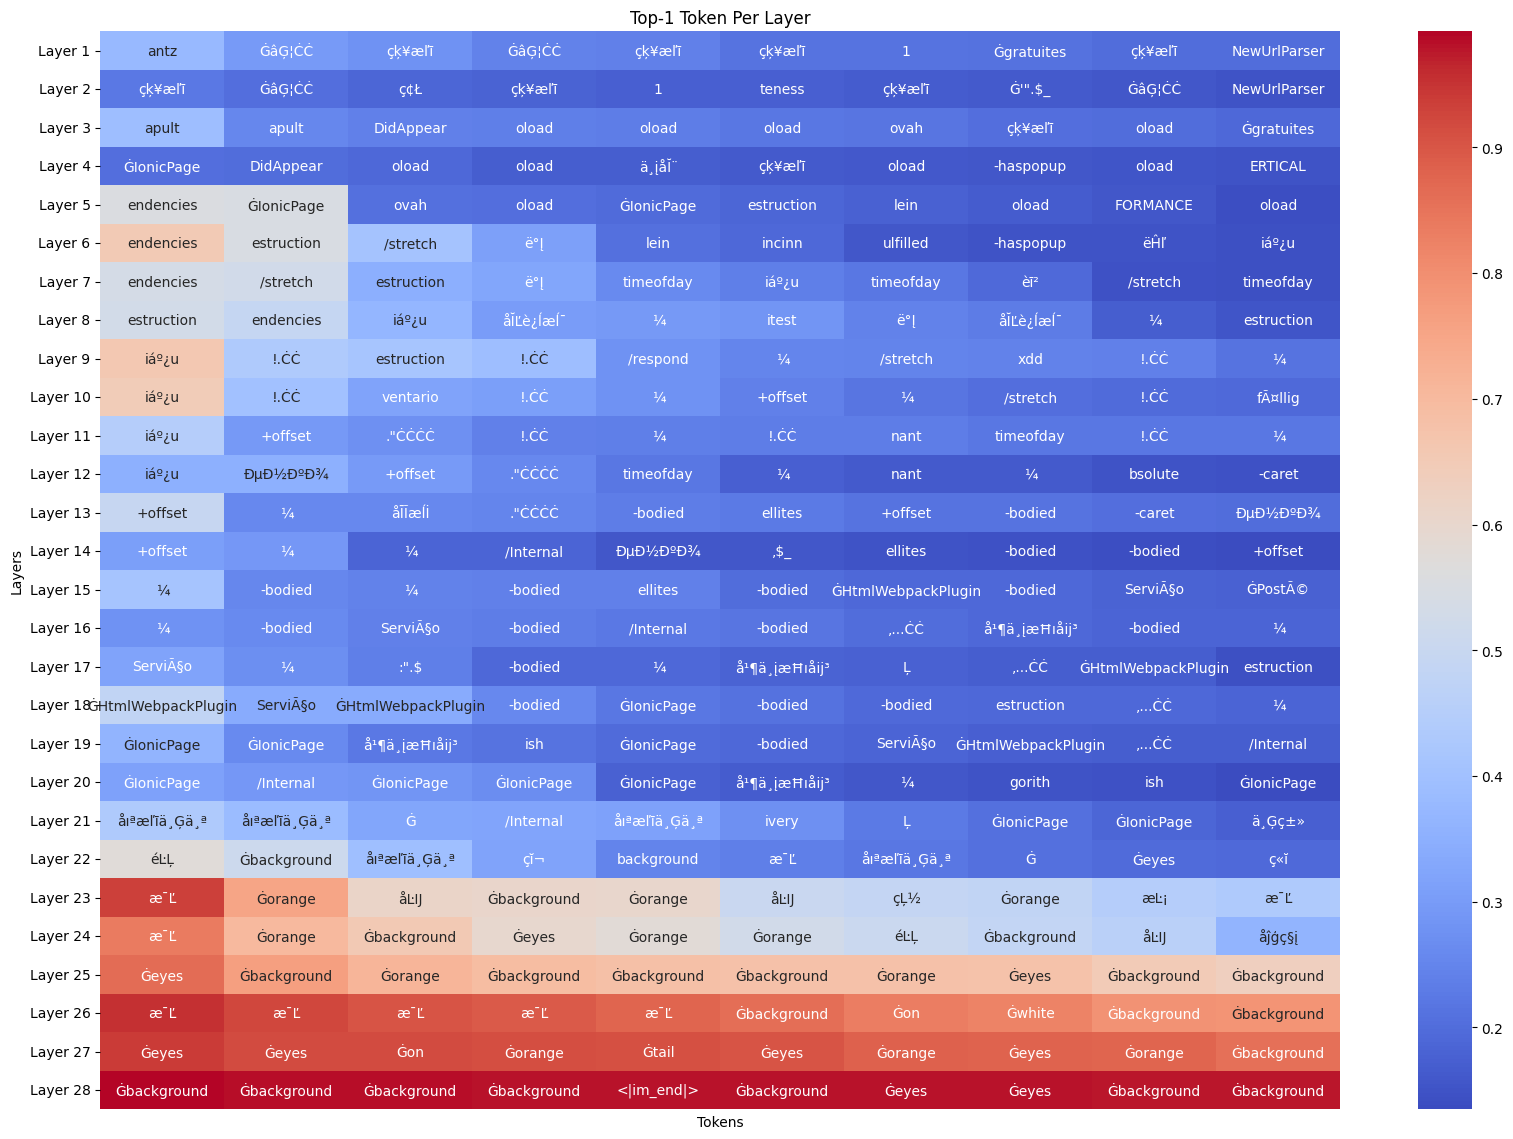

In [ ]:
logit_lens.print_top1_per_layer(norm=model.model.norm, mask=pixel_mask) # vision tokens

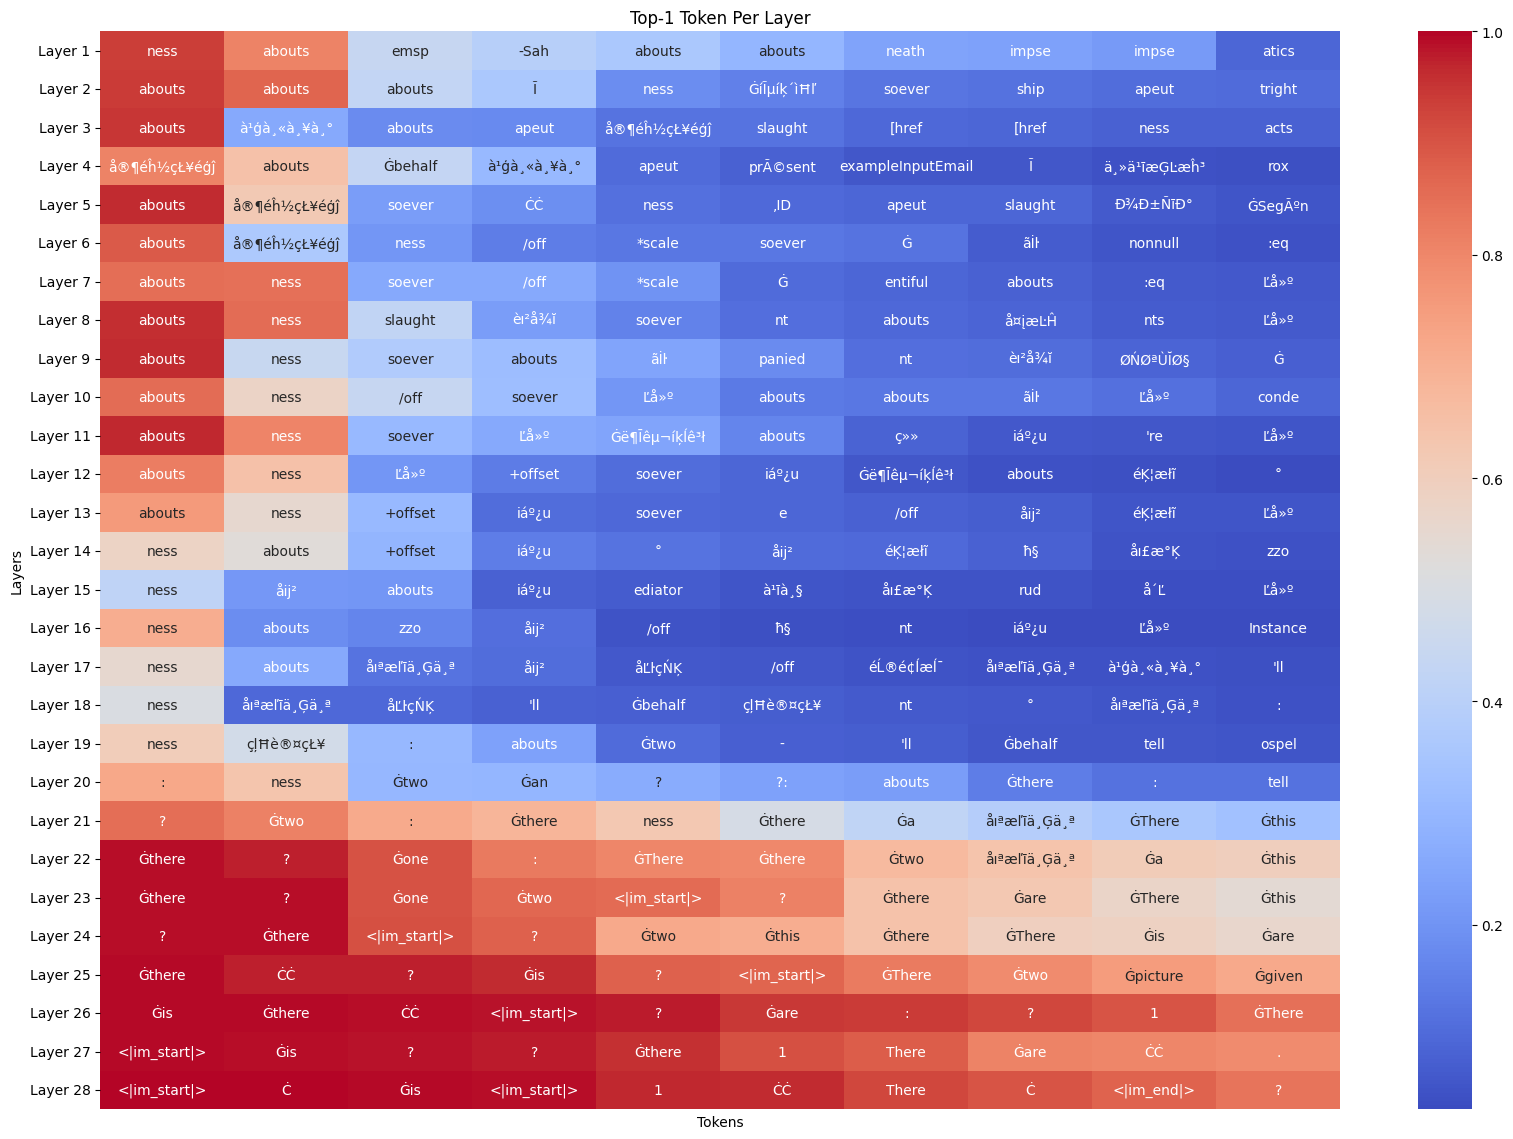

In [ ]:
logit_lens.print_top1_per_layer(norm=model.model.norm, mask=~pixel_mask)